# Team Project

In [144]:
# libraries to import
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpltlib
import seaborn as sns
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

sns.set(style="darkgrid")
%matplotlib inline

In [145]:
## read datas

# crime
crime_raw = pd.read_csv("Neighbourhood_Crime_Rates.csv")

# neighbourhood data
neighbourhood_raw = pd.read_csv("neighbourhood-profiles-2016-140-model.csv")


In [146]:
# keep relevant variables for analysis. since the other csv contains data from 2016, only focus on 2016 data
crime_2016 = crime_raw[['Neighbourhood', 'Assault_2016', 'Assault_Rate2016', 'AutoTheft_2016', 'AutoTheft_Rate2016',
                      'BreakAndEnter_2016', 'BreakAndEnter_Rate2016', 'Robbery_2016', 'Robbery_Rate2016',
                      'TheftOver_2016', 'TheftOver_Rate2016', 'Homicide_2016', 'Homicide_Rate2016',
                      'Shootings_2016', 'Shootings_Rate2016']]

In [147]:
%%capture --no-display
# David's heat map stuff
tor_map = "Neighbourhoods.shp"
# read .shp file and make a common joining factor
regions = gpd.read_file(tor_map)
regions['neighbourhood'] = regions['FIELD_7'].str.replace(' \(.+\)', '')
# keep coordinates, polygons, and neighbourhood name
regions_cleaned = regions[['FIELD_11', 'FIELD_12', 'geometry', 'neighbourhood']]
regions_cleaned = regions_cleaned.rename(columns={'FIELD_11':'longitute', 'FIELD_12':'latitude'})


In [149]:
# join crime data and heat map data
crime_regions = regions_cleaned.set_index('neighbourhood').join(crime_2016.set_index('Neighbourhood'))
crime_regions = crime_regions.reset_index()
crime_regions = crime_regions.fillna(0)

# create a total crimes
crime_regions['TotalCrimes_2016'] = crime_regions['Assault_2016']+ \
                            crime_regions['AutoTheft_2016']+ \
                            crime_regions['BreakAndEnter_2016']+ \
                            crime_regions['Robbery_2016']+ \
                            crime_regions['TheftOver_2016']+ \
                            crime_regions['Homicide_2016']+ \
                            crime_regions['Shootings_2016']

# create "property" type crimes variable
crime_regions['PropertyCrimes_2016'] = crime_regions['AutoTheft_2016'] + crime_regions['BreakAndEnter_2016'] + crime_regions['Robbery_2016'] + crime_regions['TheftOver_2016']

# create "violence" type crimes variable
crime_regions['ViolenceCrimes_2016'] = crime_regions['Assault_2016'] + crime_regions['Homicide_2016']+ crime_regions['Shootings_2016']


In [150]:
# Unpivot the neighbourhood dataframe
neighbourhood = pd.melt(neighbourhood_raw, id_vars=['Category','Topic','Data Source','Characteristic'])

In [152]:
# cleaning neighbourhood
# remove rows that are not neighbourhood

# remove rows whith variable = '_id'
neighbourhood = neighbourhood.drop(
    neighbourhood[neighbourhood["variable"] == '_id'].index
)

# remove rows whith variable = 'City of Toronto'
neighbourhood = neighbourhood.drop(
    neighbourhood[neighbourhood["variable"] == 'City of Toronto'].index
)

# now in the neighbourhood we have only neighbourhood

In [153]:
# adjust column names
neighbourhood = neighbourhood.rename(columns={'Category': 'category', 'Topic': 'topic', 'Data Source': 'data_source', 'Characteristic':'characteristic', 'variable': 'neighbourhood'})


In [154]:
# return a dataframe filtering values from neighbourhood dataframme
def neighbourhoodDataframeValueFiltered(column, filter):
    newDataframe = neighbourhood[['characteristic','neighbourhood','value']].query('characteristic == "'+filter+'"')
    
    # adjust column name
    newDataframe = newDataframe.rename(columns={'value': column})

    # adjust type of column to int
    newDataframe[column] = newDataframe[column].str.replace(',', '')
    newDataframe = newDataframe.astype({column: float})
    newDataframe = newDataframe.drop('characteristic', axis=1)
    
    # return dataFrame 
    return newDataframe

In [155]:
# dictionary with column name and condition to add from neighbourhood to crime_regions
dict_columns = {}
dict_columns['population'] = 'Population, 2016'
dict_columns['children'] = 'Children (0-14 years)'
dict_columns['youth']='Youth (15-24 years)'
dict_columns['workingAge']='Working Age (25-54 years)'
dict_columns['preRetirement']='Pre-retirement (55-64 years)'
dict_columns['seniors']='Seniors (65+ years)'
dict_columns['olderSeniors']='Older Seniors (85+ years)'
dict_columns['seniors_alone']='Persons age 65+ living alone (total)'
dict_columns['income']='Total income: Average amount ($)'
dict_columns['education']='Total - Highest certificate, diploma or degree for the population aged 15 years and over in private households - 25% sample data'
dict_columns['indigenous']='Total - Aboriginal identity for the population in private households - 25% sample data'
dict_columns['unemployment']='Employment rate'


In [156]:
# loop to add columns to crime_regions
for column in dict_columns:
    crime_regions = crime_regions.merge(neighbourhoodDataframeValueFiltered(column, dict_columns[column]), left_on='neighbourhood', right_on='neighbourhood')


In [212]:
# convert variables to per capita measures (per 100000 people)
population_variables = ['children', 'youth', 'workingAge', 'preRetirement', 'seniors', 'olderSeniors', 'seniors_alone', 'education', 'indigenous']
population_variables_colnames = [s + '_percapita' for s in population_variables]
# this should work but isn't generating the right numbers
# crime_regions[population_variables_colnames] = crime_regions.apply(lambda x: (x[population_variables]/x.population * 100000), axis=1)
for var in population_variables:
    crime_regions[var + '_percapit'] = crime_regions[var]/crime_regions['population']* 1000000

In [204]:
crime_regions.head(10)

,neighbourhood,longitute,latitude,geometry,Assault_2016,Assault_Rate2016,AutoTheft_2016,AutoTheft_Rate2016,BreakAndEnter_2016,BreakAndEnter_Rate2016,...,unemployment,children_percapita,youth_percapita,workingAge_percapita,preRetirement_percapita,seniors_percapita,olderSeniors_percapita,seniors_alone_percapita,education_percapita,indigenous_percapita
0,Wychwood,-79.425515,43.676919,"POLYGON ((-79.43592 43.68015, -79.43492 43.680...",80.0,540.5771,18.0,121.62980,30.0,202.71640,...,65.6,12962.575789,9199.247334,44741.793853,11115.757196,21952.749321,6132.831556,4808.697470,79343.508258,92340.929682
1,Yonge-Eglinton,-79.403590,43.704689,"POLYGON ((-79.41096 43.70408, -79.40962 43.704...",67.0,547.5646,4.0,32.69042,19.0,155.27950,...,68.2,15232.292460,10366.421258,49589.574342,11212.659728,13539.815520,1396.293476,5035.118897,84623.847000,99898.451384
2,Yonge-St.Clair,-79.397871,43.687859,"POLYGON ((-79.39119 43.68108, -79.39141 43.680...",34.0,262.5482,7.0,54.05405,12.0,92.66409,...,65.2,9658.365262,7343.550447,47573.435504,12292.464879,23188.058748,3751.596424,8181.673052,88601.532567,98140.166028
3,York University Heights,-79.488883,43.765736,"POLYGON ((-79.50529 43.75987, -79.50488 43.759...",363.0,1269.3200,106.0,370.65530,98.0,342.68130,...,56.3,14659.515094,17214.510927,44540.281956,10745.478926,12793.099699,1449.643025,2609.357446,85239.009894,99898.524988
4,Yorkdale-Glen Park,-79.457108,43.714672,"POLYGON ((-79.43969 43.70561, -79.44011 43.705...",175.0,1149.1990,41.0,269.24090,66.0,433.41210,...,55.3,13239.664955,12631.721156,39583.896244,12226.425290,22257.497974,5235.071602,4120.507971,81498.243718,94771.683329
5,Lambton Baby Point,-79.496045,43.657420,"POLYGON ((-79.50552 43.66281, -79.50577 43.662...",20.0,243.4275,1.0,12.17137,9.0,109.54240,...,61.8,21227.301190,11333.750783,41452.723857,13149.655604,12836.568566,1753.287414,3944.896681,78710.081403,100000.000000
6,Lansing-Westgate,-79.424748,43.754271,"POLYGON ((-79.43998 43.76156, -79.44004 43.761...",67.0,400.6698,26.0,155.48380,41.0,245.18600,...,62.5,14971.541698,13022.766642,46956.198961,11816.382084,13363.028953,2227.171492,3340.757238,84446.919079,99356.594902
7,Lawrence Park North,-79.403978,43.730060,"POLYGON ((-79.39008 43.72768, -79.39199 43.727...",22.0,146.5397,13.0,86.59162,27.0,179.84410,...,65.9,22454.987335,11432.874649,40939.275690,11809.406449,13247.073321,1814.198672,3731.087835,77189.018964,99712.466626
8,Lawrence Park South,-79.406039,43.717212,"POLYGON ((-79.41096 43.70408, -79.41165 43.703...",19.0,121.7558,20.0,128.16400,44.0,281.96090,...,63.1,18743.000198,13801.963239,38671.849265,13933.724224,14724.290138,2075.235523,3294.024639,80835.364649,99578.364846
9,Leaside-Bennington,-79.366072,43.703797,"POLYGON ((-79.37749 43.71309, -79.37762 43.713...",38.0,220.0985,4.0,23.16826,33.0,191.13810,...,63.7,19521.036368,12924.887093,38358.687901,13905.395769,15153.315902,2376.990730,4219.158545,79421.202757,98912.526741


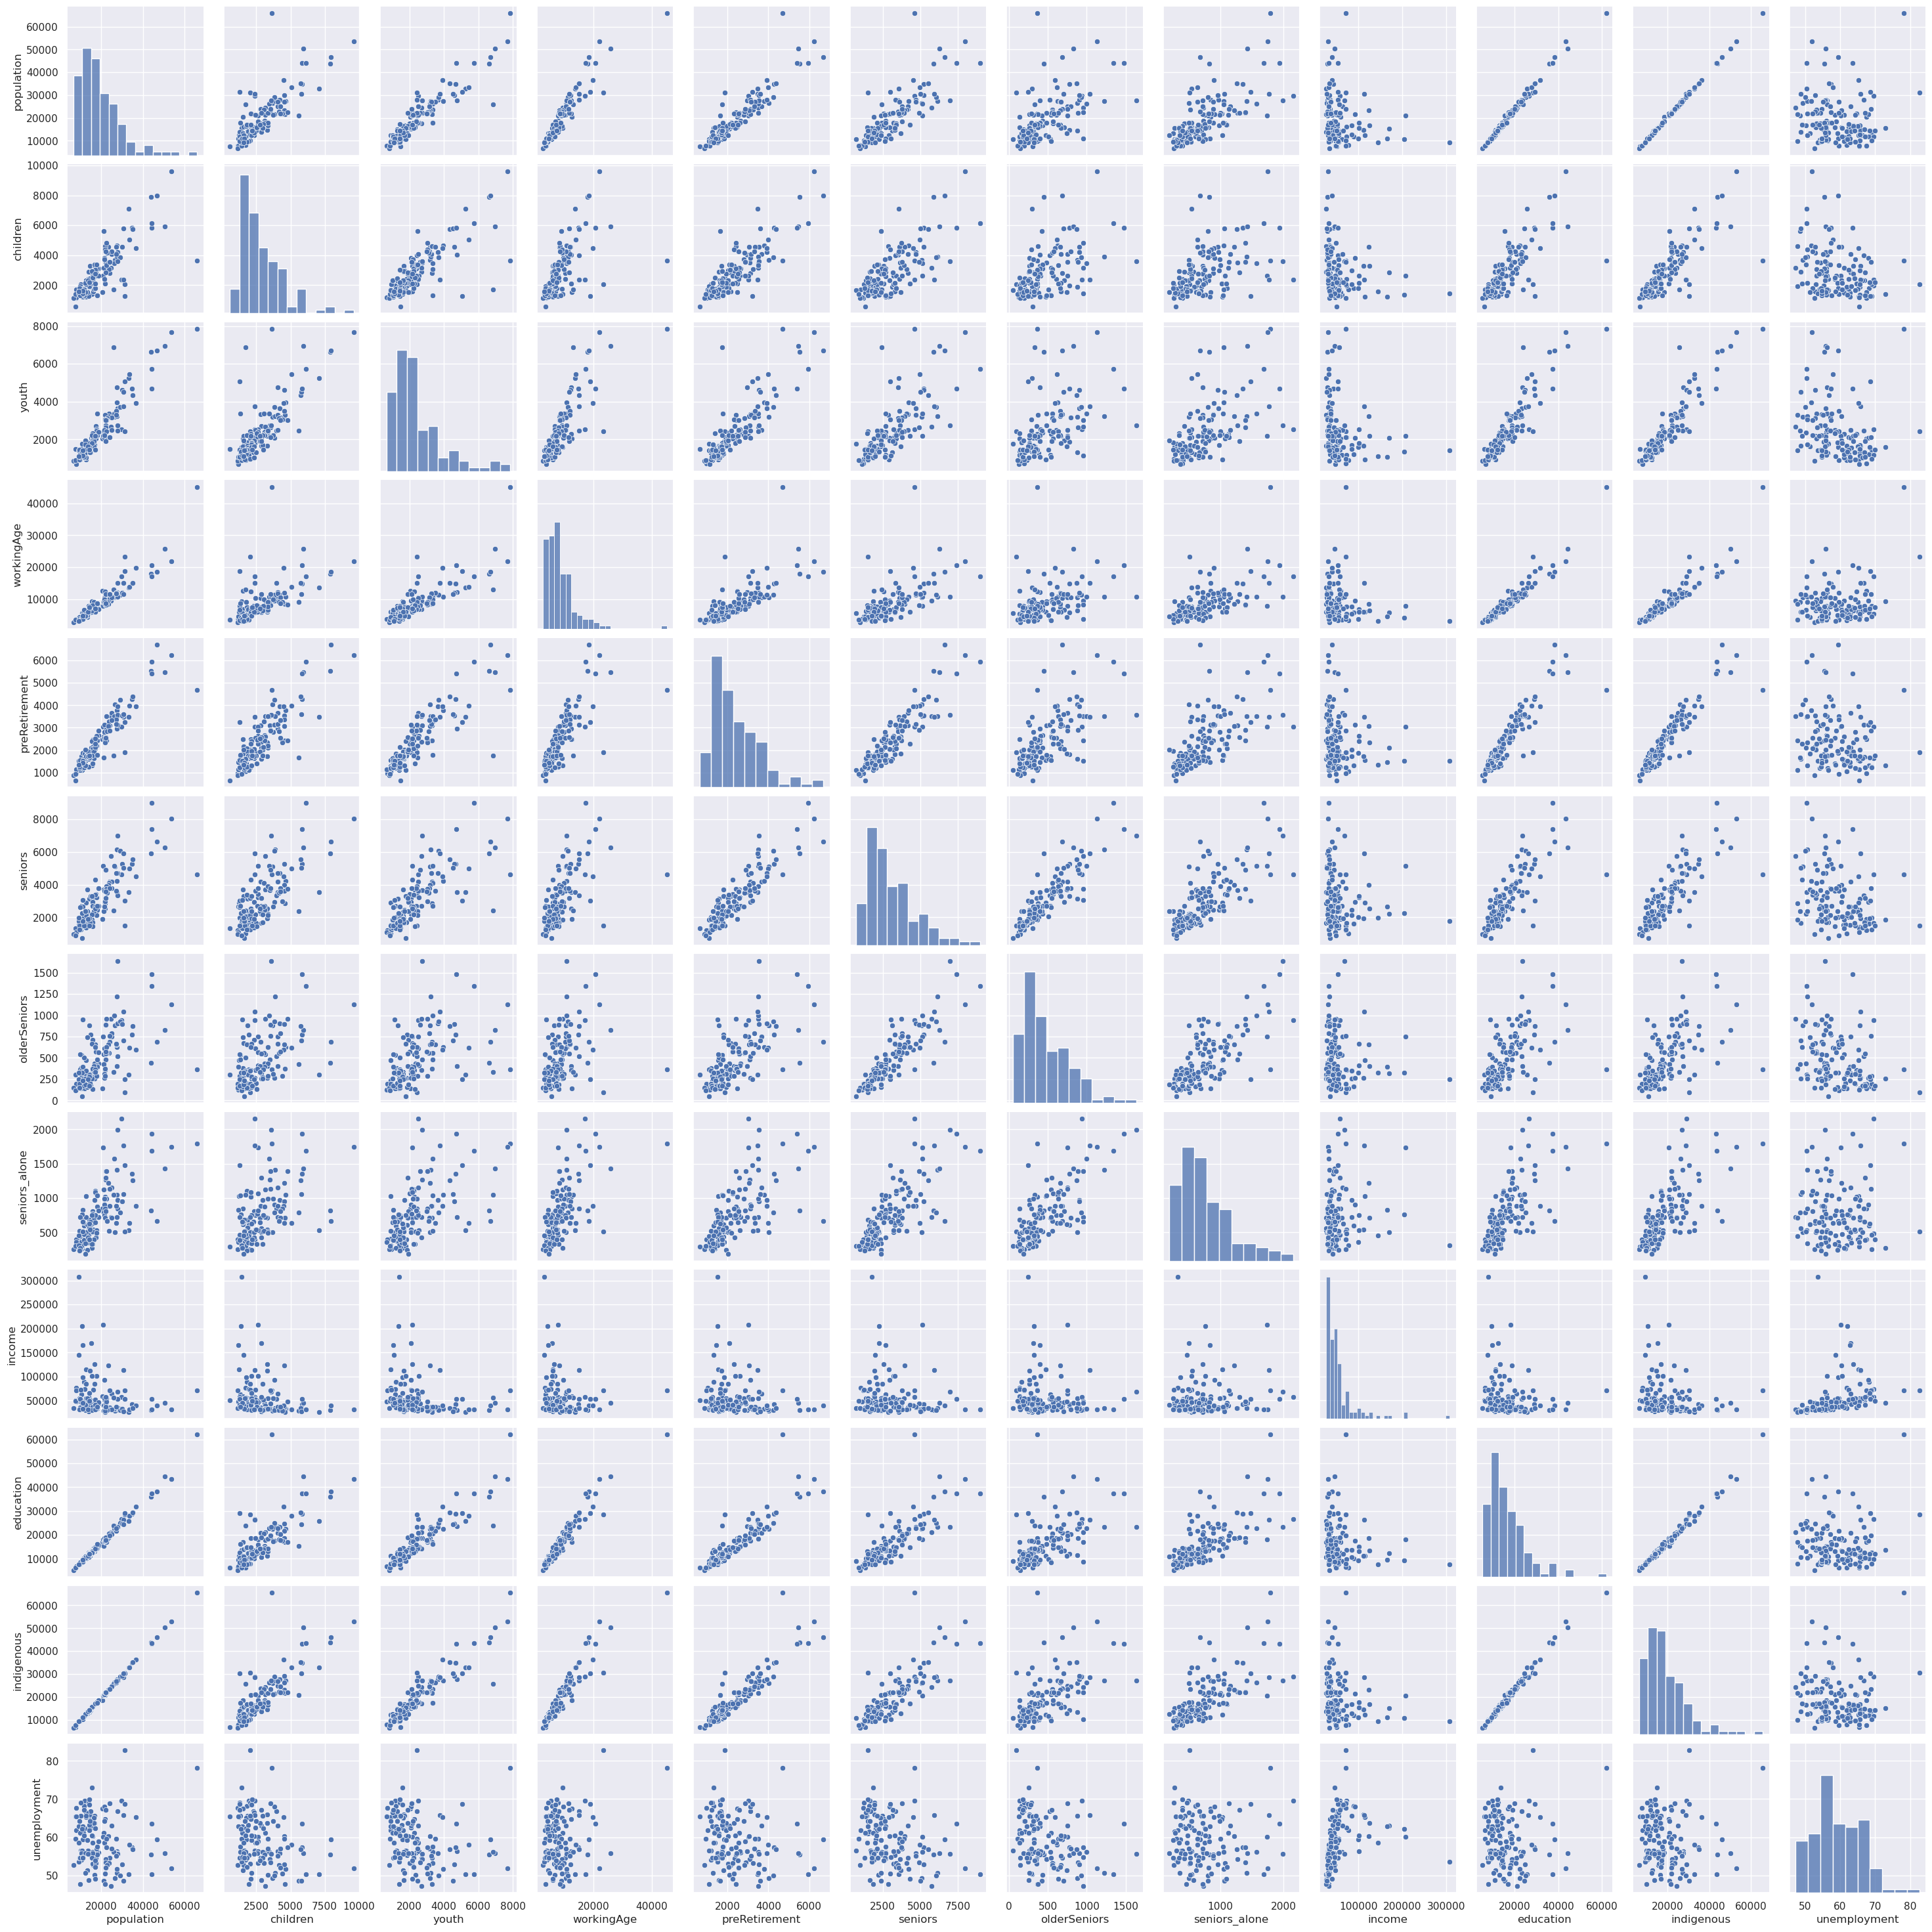

In [161]:
sns.pairplot(crime_regions[predictor_headers])

In [160]:
# david's stats stuff
lreg = LinearRegression()
sfs1 = sfs(lreg, k_features=3, forward=False, verbose=1, scoring='neg_mean_squared_error')

predictor_headers = list(crime_regions.columns)
predictor_headers = predictor_headers[21:]

# define predictors to be tested and dependent variable
x = crime_regions[predictor_headers]
y = crime_regions['TotalCrimes_2016']

x = sm.add_constant(x)

# fit regression model
model = sm.OLS(y, x).fit()

x2 = crime_regions[['indigenous']]
x2 = sm.add_constant(x2)
model2 = sm.OLS(y, x2).fit()
print(model2.summary())

# # view model summary. any variables with a p-value > 0.05 are deemeed insignificant at the 0.05 significance level
# # print(model.summary())
# # base model has AIC value of 1623. the lower value, the better the model!

# sfs1 = sfs1.fit(x, y)

# # list of variables that the algorithm decided to keep
# feat_names = list(sfs1.k_feature_names_)
# # use this new set of predictors!
# new_data = crime_regions[feat_names]
# new_data = sm.add_constant(new_data)

# model2 = sm.OLS(y, new_data).fit()
# print(model2.summary())

# there is multicollinearity so this is a lot more difficult.

                            OLS Regression Results                            
Dep. Variable:       TotalCrimes_2016   R-squared:                       0.478
Model:                            OLS   Adj. R-squared:                  0.474
Method:                 Least Squares   F-statistic:                     122.7
Date:                Tue, 06 Dec 2022   Prob (F-statistic):           1.19e-20
Time:                        00:02:10   Log-Likelihood:                -866.51
No. Observations:                 136   AIC:                             1737.
Df Residuals:                     134   BIC:                             1743.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -23.9499     26.670     -0.898      0.3

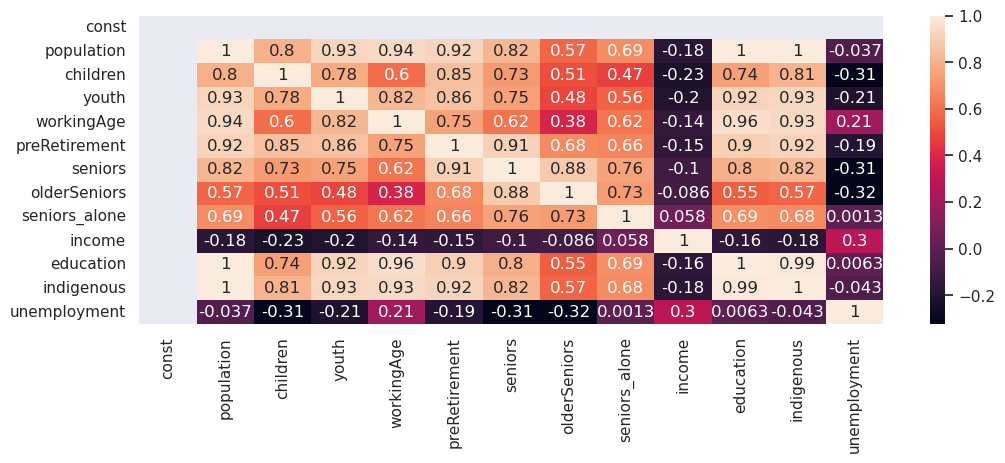

In [140]:
# create correlation matrix to observe multicollinearity
matrix = x.corr(method = 'pearson', min_periods = 1)
sns.heatmap(matrix, annot = True)
plt.show()

In [ ]:
%%capture --no-display
# Heat Map of Assaults by Neighbourhood in Toronto
fig, ax = plt.subplots(1, figsize=(40, 20))
ax.axis('off')
ax.set_title('Heat Map of Assaults by Neighbourhood in Toronto, Ontario', fontdict={'fontsize': '40', 'fontweight' : '3'})

color = 'Oranges'
vmin, vmax = 0, crime_regions['Assault_2016'].max()
sm = plt.cm.ScalarMappable(cmap=color, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)
cbar.ax.tick_params(labelsize=20)

crime_regions.plot('Assault_2016', cmap=color, linewidth=0.8, ax=ax, edgecolor='0.8', figsize=(40,20))
for idx, row in crime_regions.iterrows():
    if(row['Assault_2016'] > 250):
        plt.annotate(text=row['neighbourhood'], xy=(row['longitute'], row['latitude']),
                 horizontalalignment='center', fontsize='large', color='black', wrap=True)
plt.show()

In [ ]:
%%capture --no-display
# Heat Map of Property Related Crimes by Neighbourhood in Toronto

fig, ax = plt.subplots(1, figsize=(40, 20))
ax.axis('off')
ax.set_title('Heat Map of Property Related Crimes by Neighbourhood in Toronto, Ontario', fontdict={'fontsize': '40', 'fontweight' : '3'})

color = 'Blues'
vmin, vmax = 0, crime_regions['PropertyCrimes_2016'].max()
sm = plt.cm.ScalarMappable(cmap=color, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)
cbar.ax.tick_params(labelsize=20)

crime_regions.plot('PropertyCrimes_2016', cmap=color, linewidth=0.8, ax=ax, edgecolor='0.8', figsize=(40,20))
for idx, row in crime_regions.iterrows():
    if(row['PropertyCrimes_2016'] > crime_regions['PropertyCrimes_2016'].mean()):
        plt.annotate(text=row['neighbourhood'], xy=(row['longitute'], row['latitude']),
                 horizontalalignment='center', fontsize='large', color='black', wrap=True)
plt.show()

In [ ]:
%%capture --no-display
# Heat Map of Violence Related Crimes by Neighbourhood in Toronto

fig, ax = plt.subplots(1, figsize=(40, 20))
ax.axis('off')
ax.set_title('Heat Map of Violence Related Crimes by Neighbourhood in Toronto, Ontario', fontdict={'fontsize': '40', 'fontweight' : '3'})

color = 'Greens'
vmin, vmax = 0, crime_regions['ViolenceCrimes_2016'].max()
sm = plt.cm.ScalarMappable(cmap=color, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)
cbar.ax.tick_params(labelsize=20)

crime_regions.plot('ViolenceCrimes_2016', cmap=color, linewidth=0.8, ax=ax, edgecolor='0.8', figsize=(40,20))
for idx, row in crime_regions.iterrows():
    if(row['ViolenceCrimes_2016'] > crime_regions['ViolenceCrimes_2016'].mean()):
        plt.annotate(text=row['neighbourhood'], xy=(row['longitute'], row['latitude']),
                 horizontalalignment='center', fontsize='large', color='black', wrap=True)
plt.show()

In [ ]:
%%capture --no-display
# Heat Map of Crimes by Neighbourhood in Toronto
fig, ax = plt.subplots(1, figsize=(40, 20))
ax.axis('off')
ax.set_title('Heat Map of Crimes by Neighbourhood in Toronto, Ontario', fontdict={'fontsize': '40', 'fontweight' : '3'})

#color = 'Oranges'
color = 'Reds'
vmin, vmax = 0, crime_regions['TotalCrimes_2016'].max()
sm = plt.cm.ScalarMappable(cmap=color, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)
cbar.ax.tick_params(labelsize=20)

crime_regions.plot('TotalCrimes_2016', cmap=color, linewidth=0.8, ax=ax, edgecolor='0.8', figsize=(40,20))
for idx, row in crime_regions.iterrows():
    if(row['TotalCrimes_2016'] > crime_regions['TotalCrimes_2016'].mean()):
        plt.annotate(text=row['neighbourhood'], xy=(row['longitute'], row['latitude']),
                 horizontalalignment='center', fontsize='large', color='black', wrap=True)
plt.show()

In [ ]:
# assaults top 10 bar graph
crime_regions = crime_regions.sort_values(['Assault_2016'], ascending=False)

fig, ax = plt.subplots()

ax.bar(crime_regions['neighbourhood'].iloc[:10], crime_regions['Assault_2016'].iloc[:10])

ax.set_ylabel('Assaults')
ax.set_title('Number of assaults by neighbourhood (top 10)')

plt.show()

In [ ]:
# homicides
crime_regions = crime_regions.sort_values(['Homicide_2016'], ascending=False)

fig, ax = plt.subplots()
ax.bar(crime_regions['neighbourhood'].iloc[:10], crime_regions['Homicide_2016'].iloc[:10])
ax.set_ylabel('Assaults')
ax.set_title('Number of homicidee by neighbourhood (top 10)')

plt.show()

In [ ]:
plt.rc('figure', figsize=(12, 4))

x = np.arange(len(crime_regions['neighbourhood'].iloc[:5]))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()

#rects1 = ax.bar(x - width/2, men_means, width, label='Men')
assault = ax.bar(x - width/2, crime_regions['Assault_2016'].iloc[:5], width, label='Assault')
homicide = ax.bar(x + width/2, crime_regions['BreakAndEnter_2016'].iloc[:5], width, label='BreakAndEnter')
#rects2 = ax.bar(x + width/2, women_means, width, label='Women')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Crimes')
ax.set_title('Assault/Break and Enter by neighbourhood')
ax.set_xticks(x, crime_regions['neighbourhood'].iloc[:5])
ax.legend()

ax.bar_label(assault, padding=3)
ax.bar_label(homicide, padding=3)

fig.tight_layout()

plt.show()

In [ ]:
crime_regions = crime_regions.sort_values(['TotalCrimes_2016'], ascending=False)

plt.plot(crime_regions['neighbourhood'].iloc[:5],crime_regions['Assault_2016'].iloc[:5])
plt.plot(crime_regions['neighbourhood'].iloc[:5],crime_regions['AutoTheft_2016'].iloc[:5])
plt.plot(crime_regions['neighbourhood'].iloc[:5],crime_regions['BreakAndEnter_2016'].iloc[:5])
plt.plot(crime_regions['neighbourhood'].iloc[:5],crime_regions['Robbery_2016'].iloc[:5])
plt.plot(crime_regions['neighbourhood'].iloc[:5],crime_regions['TheftOver_2016'].iloc[:5])
plt.plot(crime_regions['neighbourhood'].iloc[:5],crime_regions['Homicide_2016'].iloc[:5])
plt.plot(crime_regions['neighbourhood'].iloc[:5],crime_regions['Shootings_2016'].iloc[:5])


In [ ]:
%%capture --no-display
# make smaller plots so we can visually compare them
crimes_of_interest_column_names = ["Assault_2016", "AutoTheft_2016", "BreakAndEnter_2016", "Robbery_2016", "TheftOver_2016", "Homicide_2016", "Shootings_2016"]
#colors = plt.cm.Sequential
colors = ["Oranges", "Blues", "Reds", "Greens"]

fig_width = 5
fig_height = 5

# make the plots
fig, axs = plt.subplots(ncols=len(crimes_of_interest_column_names), figsize=(fig_width * len(crimes_of_interest_column_names), fig_height))
# common settings for all plots:
for ax in axs:
    ax.axis('off')

# unique settings:
for i in range(0, len(crimes_of_interest_column_names)):
    crime_column = crimes_of_interest_column_names[i]
    #todo: fix title crime name
    axs[i].set_title(f"{crime_column}", fontdict={'fontsize': '10', 'fontweight' : '3'})

    color = colors[i % len(colors)]
    vmin, vmax = 0, crime_regions[crime_column].max()
    scalar_mappable = mpltlib.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap=color)
    
    #cbar = fig.colorbar(scalar_mappable)
    #cbar.ax.tick_params(labelsize=14)

    crime_regions.plot(crime_column, cmap=color, linewidth=0.8, ax=axs[i], edgecolor='0.8', figsize=(fig_width, fig_height))

    
plt.show()
    
#####################
discard = '''
# make the plot
fig, ax = plt.subplots(1, figsize=(10,5))
ax.axis('off')
ax.set_title('Heat Map of Unemployment', fontdict={'fontsize': '10', 'fontweight' : '3'})

color = 'Blues'
vmin, vmax = 0, 231
sm = plt.cm.ScalarMappable(cmap=color, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)
cbar.ax.tick_params(labelsize=20)

merged.plot('Assault_2016', cmap=color, linewidth=0.8, ax=ax, edgecolor='0.8', figsize=(10,5))

plt.show()
'''

In [49]:
# Unpivot the crime dataframe
crime_years = pd.melt(crime_raw, id_vars=['OBJECTID','Neighbourhood','Hood_ID','F2020_Population_Projection','Shape__Area','Shape__Length'])


In [50]:
# adjust the variable column to split
crime_years['variable'] = crime_years['variable'].str.replace('_Rate', 'Rate_')


In [51]:
# split variable column into crime_type and year
crime_years[['crime_type','year']] = crime_years['variable'].str.split('_', expand=True)


In [52]:
# remove columns that are not used
crime_years = crime_years.drop('OBJECTID', axis=1)
crime_years = crime_years.drop('Hood_ID', axis=1)
crime_years = crime_years.drop('F2020_Population_Projection', axis=1)
crime_years = crime_years.drop('Shape__Area', axis=1)
crime_years = crime_years.drop('Shape__Length', axis=1)
crime_years = crime_years.drop('variable', axis=1)


In [ ]:
crime_years